# Customer Classification




#### Use Cases
##### - Product Recommendations
##### - Sales Planning 
##### - Inventory & Cost Management

### The goal of this project is to perform Sales Analysis and Classification Customer based on Gender, Marital Status, Education Status and Credit Rating.
####  Exploratory Data Analysis
    -Data Extraction
    -Data Cleansing
    -Data Munging
    -Data Profiling
#### Model Selection
    -Feature Selection
    -Naive Bayes Model
    -Decision Tree
    -Random Model
#### Model Implementation & Evaluation
    -Train/Test Split Data
    -Train Model
    -Classification Report
    -Confusion Matrix
    -Test Scores

In [ ]:
!pip install snowflake-connector-python

In [98]:
# Import Packages

import math
import statistics
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import getpass
import snowflake.connector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')



















# SnowFlake Integration

In [2]:
'''Snowflake Connection Object'''

pwd = getpass.getpass('Enter Password:')
connection = snowflake.connector.connect(user='SAIBHARATH846', 
                                         password=str(pwd), 
                                         account='WVB49440.us-east-1')

Enter Password:········


### Data Extraction

    -Extract data from Snowflake TPC-DC Warehouse (Transaction Processing Peformance Council).

    -Implement data Completeness check joining with dimension tables and to exclude not null values.
    
    -30,000 Records

In [3]:
''' 
    Extract data from Snowflake TPC-DC Warehouse (Transaction Processing Peformance Council).
    In this query we will extract customer catalog sales history data related to various product categories, 
    brands, class items and  along with customer type/dimension attributes such as Gender, Marital Status, 
    Education Status and Credit Rating.
'''


query_catalog_sales = 'SELECT CD.CD_GENDER, CD.CD_MARITAL_STATUS, CD.CD_EDUCATION_STATUS, CD.CD_CREDIT_RATING, \
                       I.I_PRODUCT_NAME,I.I_CATEGORY, I.I_BRAND, I.I_CLASS, \
                       CS.* FROM SNOWFLAKE_SAMPLE_DATA.TPCDS_SF10TCL.CATALOG_SALES CS \
                       INNER JOIN SNOWFLAKE_SAMPLE_DATA.TPCDS_SF10TCL.ITEM I on CS.CS_ITEM_SK = I.I_ITEM_SK \
                       INNER JOIN SNOWFLAKE_SAMPLE_DATA.TPCDS_SF10TCL.CUSTOMER_DEMOGRAPHICS CD on CD.CD_DEMO_SK = CS.CS_BILL_CDEMO_SK \
                       WHERE CS.CS_SOLD_DATE_SK IS NOT NULL \
                       AND I.I_CATEGORY IS NOT NULL \
                       AND I.I_BRAND IS NOT NULL \
                       AND I.I_CLASS IS NOT NULL \
                       AND I.I_PRODUCT_NAME IS NOT NULL \
                       ORDER BY CS.CS_SOLD_DATE_SK DESC \
                       limit 30000;'

df_catalog_sales = pd.read_sql(query_catalog_sales, connection)


### Data Cleansing

In [4]:
df_catalog_sales.columns

Index(['CD_GENDER', 'CD_MARITAL_STATUS', 'CD_EDUCATION_STATUS',
       'CD_CREDIT_RATING', 'I_PRODUCT_NAME', 'I_CATEGORY', 'I_BRAND',
       'I_CLASS', 'CS_SOLD_DATE_SK', 'CS_SOLD_TIME_SK', 'CS_SHIP_DATE_SK',
       'CS_BILL_CUSTOMER_SK', 'CS_BILL_CDEMO_SK', 'CS_BILL_HDEMO_SK',
       'CS_BILL_ADDR_SK', 'CS_SHIP_CUSTOMER_SK', 'CS_SHIP_CDEMO_SK',
       'CS_SHIP_HDEMO_SK', 'CS_SHIP_ADDR_SK', 'CS_CALL_CENTER_SK',
       'CS_CATALOG_PAGE_SK', 'CS_SHIP_MODE_SK', 'CS_WAREHOUSE_SK',
       'CS_ITEM_SK', 'CS_PROMO_SK', 'CS_ORDER_NUMBER', 'CS_QUANTITY',
       'CS_WHOLESALE_COST', 'CS_LIST_PRICE', 'CS_SALES_PRICE',
       'CS_EXT_DISCOUNT_AMT', 'CS_EXT_SALES_PRICE', 'CS_EXT_WHOLESALE_COST',
       'CS_EXT_LIST_PRICE', 'CS_EXT_TAX', 'CS_COUPON_AMT', 'CS_EXT_SHIP_COST',
       'CS_NET_PAID', 'CS_NET_PAID_INC_TAX', 'CS_NET_PAID_INC_SHIP',
       'CS_NET_PAID_INC_SHIP_TAX', 'CS_NET_PROFIT'],
      dtype='object')

In [5]:
# Select required columns to build Data Classification Model
# Remove columns related to  Tax , Discount

df_catalog_sales = df_catalog_sales[['CD_GENDER', 
                                     'CD_MARITAL_STATUS',
                                     'CD_EDUCATION_STATUS',
                                     'CD_CREDIT_RATING', 
                                     'I_PRODUCT_NAME', 
                                     'I_CATEGORY',
                                     'I_CLASS', 
                                     'CS_QUANTITY',
                                     'CS_WHOLESALE_COST', 
                                     'CS_LIST_PRICE',
                                     'CS_SALES_PRICE', 
                                     'CS_EXT_DISCOUNT_AMT',
                                     'CS_EXT_SALES_PRICE', 
                                     'CS_EXT_WHOLESALE_COST',
                                     'CS_EXT_LIST_PRICE', 
                                     'CS_EXT_SHIP_COST',
                                     'CS_NET_PAID',
                                     'CS_NET_PROFIT']]

In [6]:
df_catalog_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CD_GENDER              30000 non-null  object 
 1   CD_MARITAL_STATUS      30000 non-null  object 
 2   CD_EDUCATION_STATUS    30000 non-null  object 
 3   CD_CREDIT_RATING       30000 non-null  object 
 4   I_PRODUCT_NAME         30000 non-null  object 
 5   I_CATEGORY             30000 non-null  object 
 6   I_CLASS                30000 non-null  object 
 7   CS_QUANTITY            29954 non-null  float64
 8   CS_WHOLESALE_COST      29950 non-null  float64
 9   CS_LIST_PRICE          29960 non-null  float64
 10  CS_SALES_PRICE         29955 non-null  float64
 11  CS_EXT_DISCOUNT_AMT    29955 non-null  float64
 12  CS_EXT_SALES_PRICE     29956 non-null  float64
 13  CS_EXT_WHOLESALE_COST  29950 non-null  float64
 14  CS_EXT_LIST_PRICE      29955 non-null  float64
 15  CS

In [7]:
df_catalog_sales.shape

(30000, 18)

In [8]:
# Check individual catergory sale counts

df_catalog_sales_category = df_catalog_sales['I_CATEGORY'].value_counts()
print(df_catalog_sales_category)

Children       3233
Electronics    3203
Music          3156
Books          3122
Jewelry        3014
Men            2964
Shoes          2953
Women          2935
Home           2774
Sports         2646
Name: I_CATEGORY, dtype: int64


In [13]:
# Handle NA values
df_catalog_sales.replace('', np.nan, inplace=True)
df_catalog_sales.fillna(value=np.nan, inplace=True)
df_catalog_sales.dropna(axis=0, inplace=True)

In [14]:
df_catalog_sales.isna().sum()

CD_GENDER                0
CD_MARITAL_STATUS        0
CD_EDUCATION_STATUS      0
CD_CREDIT_RATING         0
I_PRODUCT_NAME           0
I_CATEGORY               0
I_CLASS                  0
CS_QUANTITY              0
CS_WHOLESALE_COST        0
CS_LIST_PRICE            0
CS_SALES_PRICE           0
CS_EXT_DISCOUNT_AMT      0
CS_EXT_SALES_PRICE       0
CS_EXT_WHOLESALE_COST    0
CS_EXT_LIST_PRICE        0
CS_EXT_SHIP_COST         0
CS_NET_PAID              0
CS_NET_PROFIT            0
dtype: int64

In [11]:
# Handle Duplicates
duplicates = df_catalog_sales.duplicated()
duplicates.any()

False

In [15]:
# Exclude non-negative Net Profit Values - We will use later
df_catalog_sales = df_catalog_sales.loc[df_catalog_sales['CS_NET_PROFIT'] >= 0]

In [16]:
# Remove whitespace from string columns
df_catalog_sales = df_catalog_sales.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [17]:
# Summary Statistics
df_catalog_sales.describe()

,CS_QUANTITY,CS_WHOLESALE_COST,CS_LIST_PRICE,CS_SALES_PRICE,CS_EXT_DISCOUNT_AMT,CS_EXT_SALES_PRICE,CS_EXT_WHOLESALE_COST,CS_EXT_LIST_PRICE,CS_EXT_SHIP_COST,CS_NET_PAID,CS_NET_PROFIT
count,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000
mean,50.972396,50.487395,113.121852,82.844613,1537.546551,4217.713017,2567.552048,5755.259568,1448.409931,4134.086893,1566.534846
std,28.653050,28.529743,70.062102,54.196694,2016.258617,3958.075685,2203.592655,5219.011567,1742.847658,3891.086427,2074.742133
min,1.000000,1.000000,1.450000,1.080000,0.000000,1.240000,1.050000,1.760000,0.000000,1.240000,0.000000
25%,26.000000,25.790000,55.500000,39.440000,207.760000,1170.130000,765.120000,1661.060000,231.600000,1146.600000,211.890000
50%,51.000000,50.640000,106.240000,76.320000,740.900000,3040.500000,1937.130000,4215.620000,790.020000,2967.840000,764.730000
75%,75.000000,74.900000,165.150000,116.630000,2056.310000,6152.500000,3902.580000,8534.400000,2017.600000,6056.640000,2060.400000
max,100.000000,100.000000,295.530000,290.700000,14666.000000,26892.000000,9899.000000,29343.000000,11600.640000,26892.000000,17807.000000


#### Handle Outliers

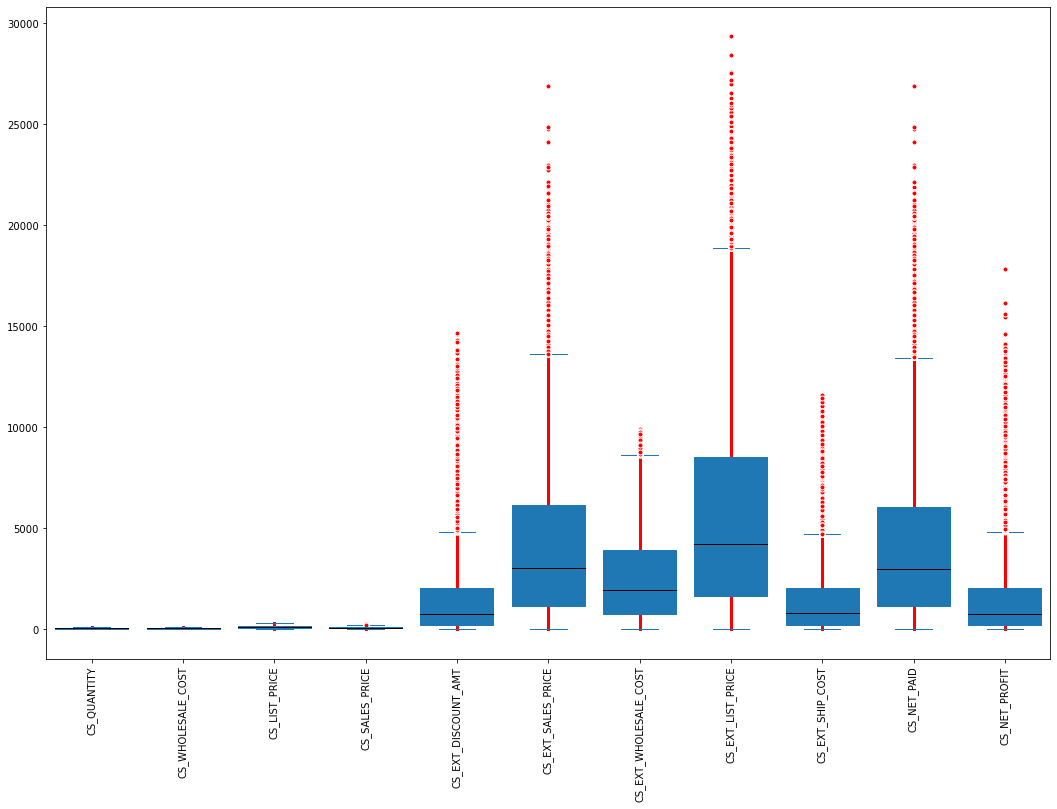

In [18]:
# Create a box plot 

outlier_check_columns = ['CD_GENDER', 
                         'CD_MARITAL_STATUS',
                         'CD_EDUCATION_STATUS',
                         'CD_CREDIT_RATING', 
                         'I_PRODUCT_NAME', 
                         'I_CATEGORY',
                         'I_CLASS', 
                         'CS_QUANTITY',
                         'CS_WHOLESALE_COST', 
                         'CS_LIST_PRICE',
                         'CS_SALES_PRICE', 
                         'CS_EXT_DISCOUNT_AMT',
                         'CS_EXT_SALES_PRICE', 
                         'CS_EXT_WHOLESALE_COST',
                         'CS_EXT_LIST_PRICE', 
                         'CS_EXT_SHIP_COST',
                         'CS_NET_PAID',
                         'CS_NET_PROFIT']


fig, ax = plt.subplots(figsize=(18, 12))
df_catalog_sales[outlier_check_columns].plot(kind='box', ax=ax, widths=0.8,
                             whiskerprops={'color': 'red', 'linewidth': 3},
                              flierprops={'marker': 'o', 'markerfacecolor': 'red', 
                                          'markersize': 5, 
                                          'markeredgecolor': 'white', 
                                          'linewidth': 1.5},
                             medianprops={'color': 'black'},
                             patch_artist=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

In [19]:
# Define a function to check for outliers, tweaking oultier multiper to 9 due to randomness of data

def detect_outliers(col, df):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

# Apply the function to each column and print the results
columns = ['CS_QUANTITY',
           'CS_WHOLESALE_COST', 
           'CS_LIST_PRICE',
           'CS_SALES_PRICE', 
           'CS_EXT_DISCOUNT_AMT',
           'CS_EXT_SALES_PRICE', 
           'CS_EXT_WHOLESALE_COST',
           'CS_EXT_LIST_PRICE', 
           'CS_EXT_SHIP_COST',
           'CS_NET_PAID',
           'CS_NET_PROFIT']

for col in columns:
    outliers = detect_outliers(col, df_catalog_sales)

# Remove the outliers from the original dataframe
df_catalog_sales = df_catalog_sales[~df_catalog_sales.index.isin(outliers.index)]
    


In [20]:
df_catalog_sales.shape

(10779, 18)

### Data Profiling

<AxesSubplot:>

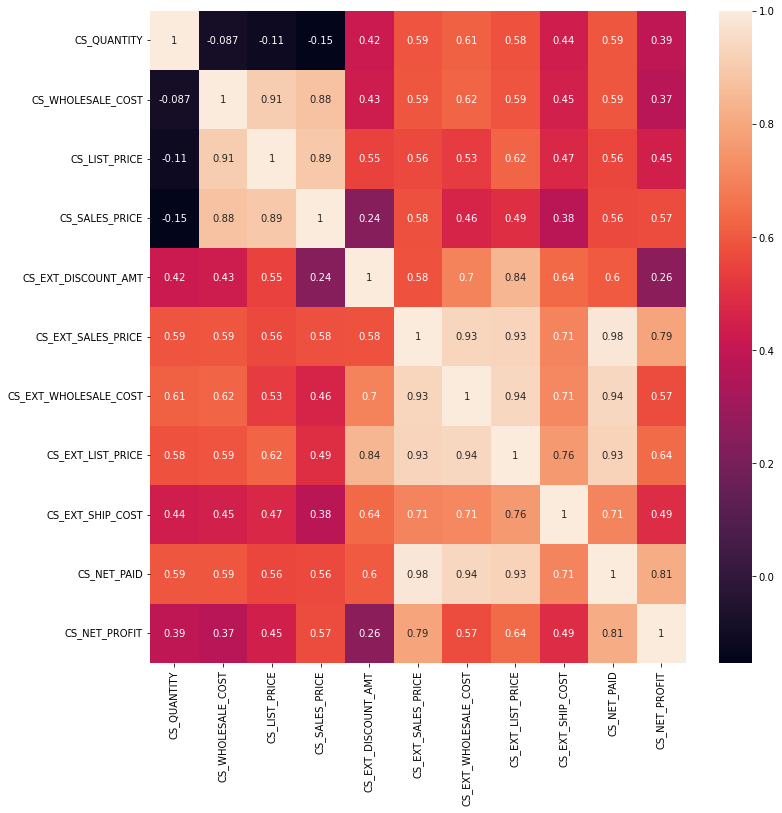

In [21]:
# Heat Map to show correlation between data attributes
# We can observe high correlation on the lighter side of the cells 
# Example
# Positive correlation CS_EXT_SALE_PRICE -> CS_EXT_WHOLESALE_COST, CS_EXT_SALES_PRICE, CS_EXT_DISCOUNT_AMT
# Negative Correlation CS_QUANTITY -> CS_WHOLESALE_COST, CS_LIST_PRICE, CS_SALES_PRICE
plt.figure(figsize = (12,12))
sns.heatmap(df_catalog_sales.corr(), annot =True)

In [22]:
# We can also see the number of unique users and items in the dataset.
df_catalog_sales.nunique()

CD_GENDER                    2
CD_MARITAL_STATUS            5
CD_EDUCATION_STATUS          7
CD_CREDIT_RATING             4
I_PRODUCT_NAME            3832
I_CATEGORY                  10
I_CLASS                     99
CS_QUANTITY                100
CS_WHOLESALE_COST         6545
CS_LIST_PRICE             8580
CS_SALES_PRICE            7786
CS_EXT_DISCOUNT_AMT       9905
CS_EXT_SALES_PRICE       10535
CS_EXT_WHOLESALE_COST    10454
CS_EXT_LIST_PRICE        10606
CS_EXT_SHIP_COST          9888
CS_NET_PAID              10551
CS_NET_PROFIT             9989
dtype: int64

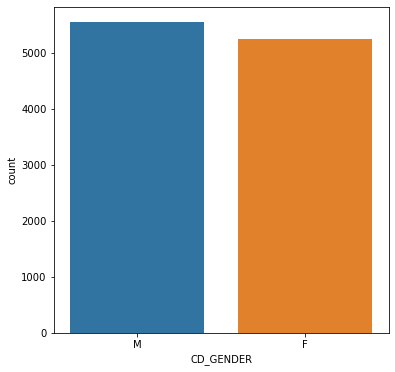

In [23]:
# Data distribution 
plt.figure(figsize=(6, 6))
sns.countplot(x='CD_GENDER', data=df_catalog_sales)
plt.show()

<Figure size 432x432 with 0 Axes>

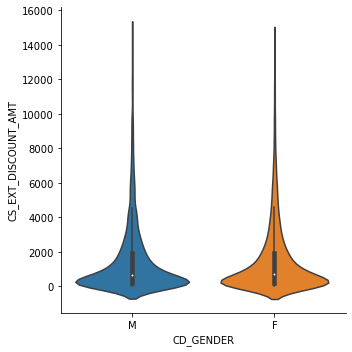

In [24]:
# Based on correlation

plt.figure(figsize=(6, 6))
sns.catplot(x="CD_GENDER", y="CS_EXT_DISCOUNT_AMT", data=df_catalog_sales, kind="violin")
plt.show()

# Volume in the range or 0-~500

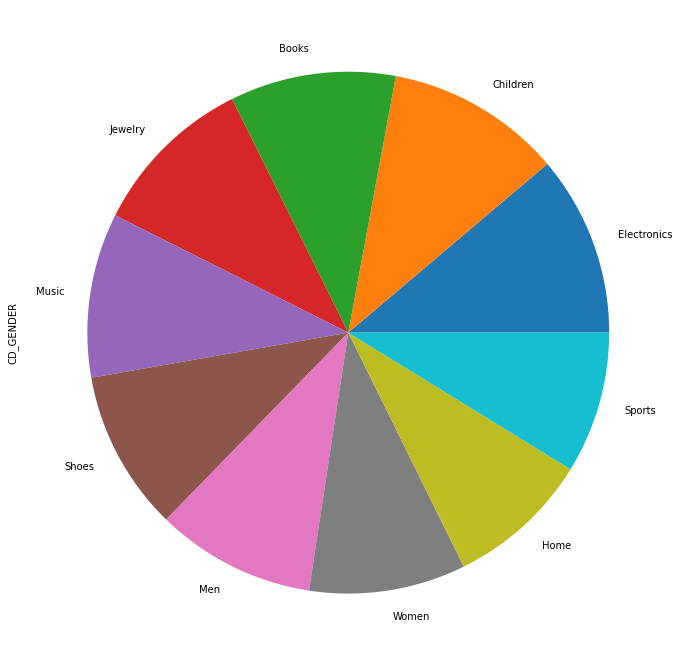

In [32]:

plt.figure(figsize=(12, 12))
df_catalog_sales.groupby('I_CATEGORY')['CD_GENDER'].count().sort_values(ascending=False).plot(kind='pie')
plt.show()

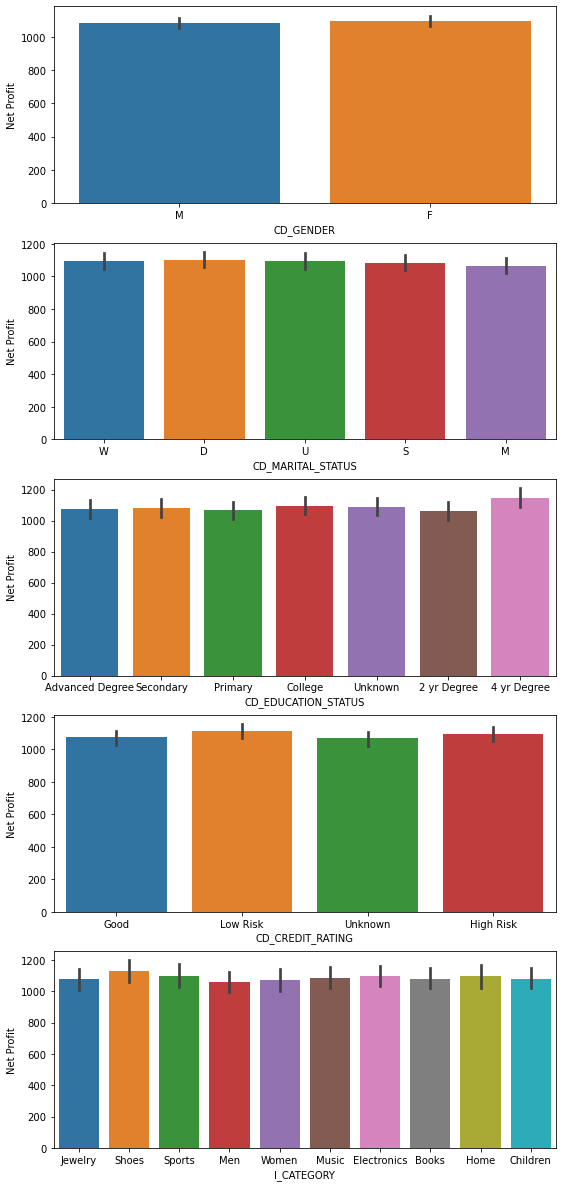

In [37]:
# NET PROFIT DISTRIBUTIONS - 

cat_cols = ['CD_GENDER', 'CD_MARITAL_STATUS', 'CD_EDUCATION_STATUS', 'CD_CREDIT_RATING', 'I_CATEGORY']
num_col = "CS_NET_PROFIT"

fig, axs = plt.subplots(len(cat_cols), figsize=(9,21))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='CS_NET_PROFIT', data=df_catalog_sales, ax=axs[i])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Net Profit')
    #axs[i].invert_yaxis()
plt.show()

In [76]:
# Drop categroical columns to define target lables, this is single label classification
#df_catalog_sales = df_catalog_sales.drop(columns=['CD_GENDER', 'CD_MARITAL_STATUS',
                                                               # 'CD_EDUCATION_STATUS',
                                                                #'CD_CREDIT_RATING', 'I_PRODUCT_NAME',
                                                               # 'I_CATEGORY', 'I_CLASS'])
df_backup = df_catalog_sales
#df_catalog_sales = df_backup

In [77]:
# Label Encoding
list_category = ['CD_GENDER', 'CD_MARITAL_STATUS', 'CD_EDUCATION_STATUS','CD_CREDIT_RATING',
                 'I_PRODUCT_NAME', 'I_CATEGORY', 'I_CLASS']
le=LabelEncoder()
for i in list_category:
    df_catalog_sales[i]=le.fit_transform(df_catalog_sales[i])

In [78]:
df_catalog_sales.head(3)

,CD_GENDER,CD_MARITAL_STATUS,CD_EDUCATION_STATUS,CD_CREDIT_RATING,I_PRODUCT_NAME,I_CATEGORY,I_CLASS,CS_QUANTITY,CS_WHOLESALE_COST,CS_LIST_PRICE,CS_SALES_PRICE,CS_EXT_DISCOUNT_AMT,CS_EXT_SALES_PRICE,CS_EXT_WHOLESALE_COST,CS_EXT_LIST_PRICE,CS_EXT_SHIP_COST,CS_NET_PAID,CS_NET_PROFIT
1,1,4,2,0,3216,4,98,96.0,15.58,31.31,24.73,631.68,2374.08,1495.68,3005.76,720.96,2374.08,878.40
2,1,0,5,2,2046,7,4,49.0,31.11,82.44,65.95,808.01,3231.55,1524.39,4039.56,726.67,3231.55,1707.16
7,1,4,4,0,3364,8,2,76.0,7.19,14.88,13.68,91.20,1039.68,546.44,1130.88,474.24,1039.68,493.24


In [80]:
y=df_catalog_sales['CD_GENDER']
X=df_catalog_sales.drop('CD_GENDER',axis=1)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

7545
3234
7545
3234


In [83]:

gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",gnb.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.47      0.22      0.30      1027
           1       0.52      0.78      0.63      1129

    accuracy                           0.51      2156
   macro avg       0.50      0.50      0.46      2156
weighted avg       0.50      0.51      0.47      2156

Confusion Matrix:
 [[227 800]
 [252 877]]
Training Score:
 51.988866983648386


In [84]:
dtree = DecisionTreeClassifier(max_depth=6, random_state=123,criterion='entropy')
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=123)

In [85]:
y_pred=dtree.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",dtree.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20      1027
           1       0.52      0.86      0.65      1129

    accuracy                           0.51      2156
   macro avg       0.48      0.49      0.42      2156
weighted avg       0.49      0.51      0.43      2156

Confusion Matrix:
 [[131 896]
 [161 968]]
Training Score:
 54.4010205264989


In [86]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [88]:
y_pred=rfc.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",rfc.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.46      0.47      0.47      1027
           1       0.51      0.50      0.50      1129

    accuracy                           0.49      2156
   macro avg       0.48      0.48      0.48      2156
weighted avg       0.49      0.49      0.49      2156

Confusion Matrix:
 [[483 544]
 [565 564]]
Training Score:
 100.0


In [89]:
# Perform Classification Prediction on Credit Rating

#df_backup = df_catalog_sales
df_catalog_sales = df_backup

In [90]:
# Label Encoding
list_category = ['CD_GENDER', 'CD_MARITAL_STATUS', 'CD_EDUCATION_STATUS','CD_CREDIT_RATING',
                 'I_PRODUCT_NAME', 'I_CATEGORY', 'I_CLASS']
le=LabelEncoder()
for i in list_category:
    df_catalog_sales[i]=le.fit_transform(df_catalog_sales[i])

In [91]:
df_catalog_sales.head(3)

,CD_GENDER,CD_MARITAL_STATUS,CD_EDUCATION_STATUS,CD_CREDIT_RATING,I_PRODUCT_NAME,I_CATEGORY,I_CLASS,CS_QUANTITY,CS_WHOLESALE_COST,CS_LIST_PRICE,CS_SALES_PRICE,CS_EXT_DISCOUNT_AMT,CS_EXT_SALES_PRICE,CS_EXT_WHOLESALE_COST,CS_EXT_LIST_PRICE,CS_EXT_SHIP_COST,CS_NET_PAID,CS_NET_PROFIT
1,1,4,2,0,3216,4,98,96.0,15.58,31.31,24.73,631.68,2374.08,1495.68,3005.76,720.96,2374.08,878.40
2,1,0,5,2,2046,7,4,49.0,31.11,82.44,65.95,808.01,3231.55,1524.39,4039.56,726.67,3231.55,1707.16
7,1,4,4,0,3364,8,2,76.0,7.19,14.88,13.68,91.20,1039.68,546.44,1130.88,474.24,1039.68,493.24


In [92]:
y=df_catalog_sales['CD_CREDIT_RATING']
X=df_catalog_sales.drop('CD_CREDIT_RATING',axis=1)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",gnb.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.24      0.15      0.18       563
           1       0.25      0.18      0.21       541
           2       0.24      0.50      0.32       527
           3       0.23      0.14      0.17       525

    accuracy                           0.24      2156
   macro avg       0.24      0.24      0.22      2156
weighted avg       0.24      0.24      0.22      2156

Confusion Matrix:
 [[ 84 117 277  85]
 [ 89 100 278  74]
 [ 91  92 261  83]
 [ 92  92 268  73]]
Training Score:
 27.12513046503537


In [95]:
dtree = DecisionTreeClassifier(max_depth=6, random_state=123,criterion='entropy')
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",dtree.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.21      0.03      0.05       563
           1       0.25      0.74      0.37       541
           2       0.22      0.06      0.10       527
           3       0.23      0.14      0.17       525

    accuracy                           0.24      2156
   macro avg       0.23      0.24      0.17      2156
weighted avg       0.23      0.24      0.17      2156

Confusion Matrix:
 [[ 15 433  42  73]
 [ 20 403  40  78]
 [ 16 396  33  82]
 [ 20 399  35  71]]
Training Score:
 28.145656963933668


In [96]:
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
print("Classification Report is:\n",classification_report(y_test,y_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("Training Score:\n",rfc.score(X_train,y_train)*100)

Classification Report is:
               precision    recall  f1-score   support

           0       0.26      0.26      0.26       563
           1       0.23      0.25      0.24       541
           2       0.28      0.29      0.29       527
           3       0.23      0.20      0.22       525

    accuracy                           0.25      2156
   macro avg       0.25      0.25      0.25      2156
weighted avg       0.25      0.25      0.25      2156

Confusion Matrix:
 [[147 175 122 119]
 [157 133 136 115]
 [133 126 155 113]
 [133 149 137 106]]
Training Score:
 100.0


In [101]:
# Train and evaluate models using cross-validation
models = [('Naive Bayes', gnb), ('Decision Tree', dtree), ('Random Forest', rfc)]

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f'{name} has an accuracy of {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# Fit the best model on the training set
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the best model on the testing set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'The accuracy of the best model on the testing set is {accuracy:.3f}')

Naive Bayes has an accuracy of 0.248 +/- 0.010
Decision Tree has an accuracy of 0.255 +/- 0.008
Random Forest has an accuracy of 0.255 +/- 0.018
The accuracy of the best model on the testing set is 0.244
